# BetterReads: Visualizing the results

This notebook makes some quick attempts to visualize our model and how it identifies the most commonly expressed views in a set of reviews. We assume the general model framework laid out in the `01_modelling_with_use.ipynb` notebook and developed further in the `02_optimizing_kmeans.ipynb` notebook.

Visualizing our model is difficult because our sentences – the data points of our model – are encoded as vectors in 512-dimensional space. Here we attempt to visualize this high-dimensional space using Principal Compenent Analysis. With PCA, we can reduce our vector space into its two most information-carrying dimensions, and then plot our data points in this reduced two-dimensional space. While this approach inevitably results in a significant amount of data loss, it is still capable of producing some meaningful visualizations.

As before, we will use the *Gone Girl* dataset for creating our visualizations. Let's begin by reading it in.

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(12.0, 9.0)
%config InlineBackend.figure_format='retina'

In [2]:
# Loads Universal Sentence Encoder locally, from downloaded module
embed = hub.load('../../Universal Sentence Encoder/module/')

# Loads Universal Sentence Encoder remotely, from Tensorflow Hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [4]:
# Set path for processed file
file_path = 'data/8442457_gone_girl.csv'

# Set number of clusters to create (k), and number of sentences to display (n)
k = 9
n = 8

# Read in processed file as dataframe
df = pd.read_csv(file_path)

# Copy sentence column to new variable
sentences = df['sentence'].copy()

# Vectorize sentences
sentence_vectors = embed(sentences)

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(sentence_vectors);

In order to reduce our sentence vectors down to two dimensions, we simply need to fit a PCA transformer to them and then transform them.

In [5]:
# Instantiate PCA transformer with 2 dimensions
pca_transform = PCA(n_components=2)

# Fit the transformer
pca_transform.fit(sentence_vectors)

# Transform our data
sentences_pca = pca_transform.transform(sentence_vectors)

print('Proportion of total variance explained by each principal component: {}'.format(pca_transform.explained_variance_ratio_))

Proportion of total variance explained by each principal component: [0.05155721 0.04239018]


As we can see here, our two principal components explain only about 9% of the total variance of our dataset. This is to be expected, since we are dealing with 512-dimensional vectors, and it means that we shouldn't expect extremely clear results from our visualizations. But let's see what they actually look like.

First let's visualize our full dataset, undifferentiated by cluster number. To do so, we create a new dataframe out of our transformed vectors.

In [6]:
# Create a dataframe out of our transformed sentence vectors
pca_df = pd.DataFrame(sentences_pca, columns=['PCA_one', 'PCA_two'])

# Add column indicating the cluster number of each sentence (adding 1 so that the first cluster is number 1, not 0)
pca_df['Cluster'] = kmeans_model.labels_ + 1

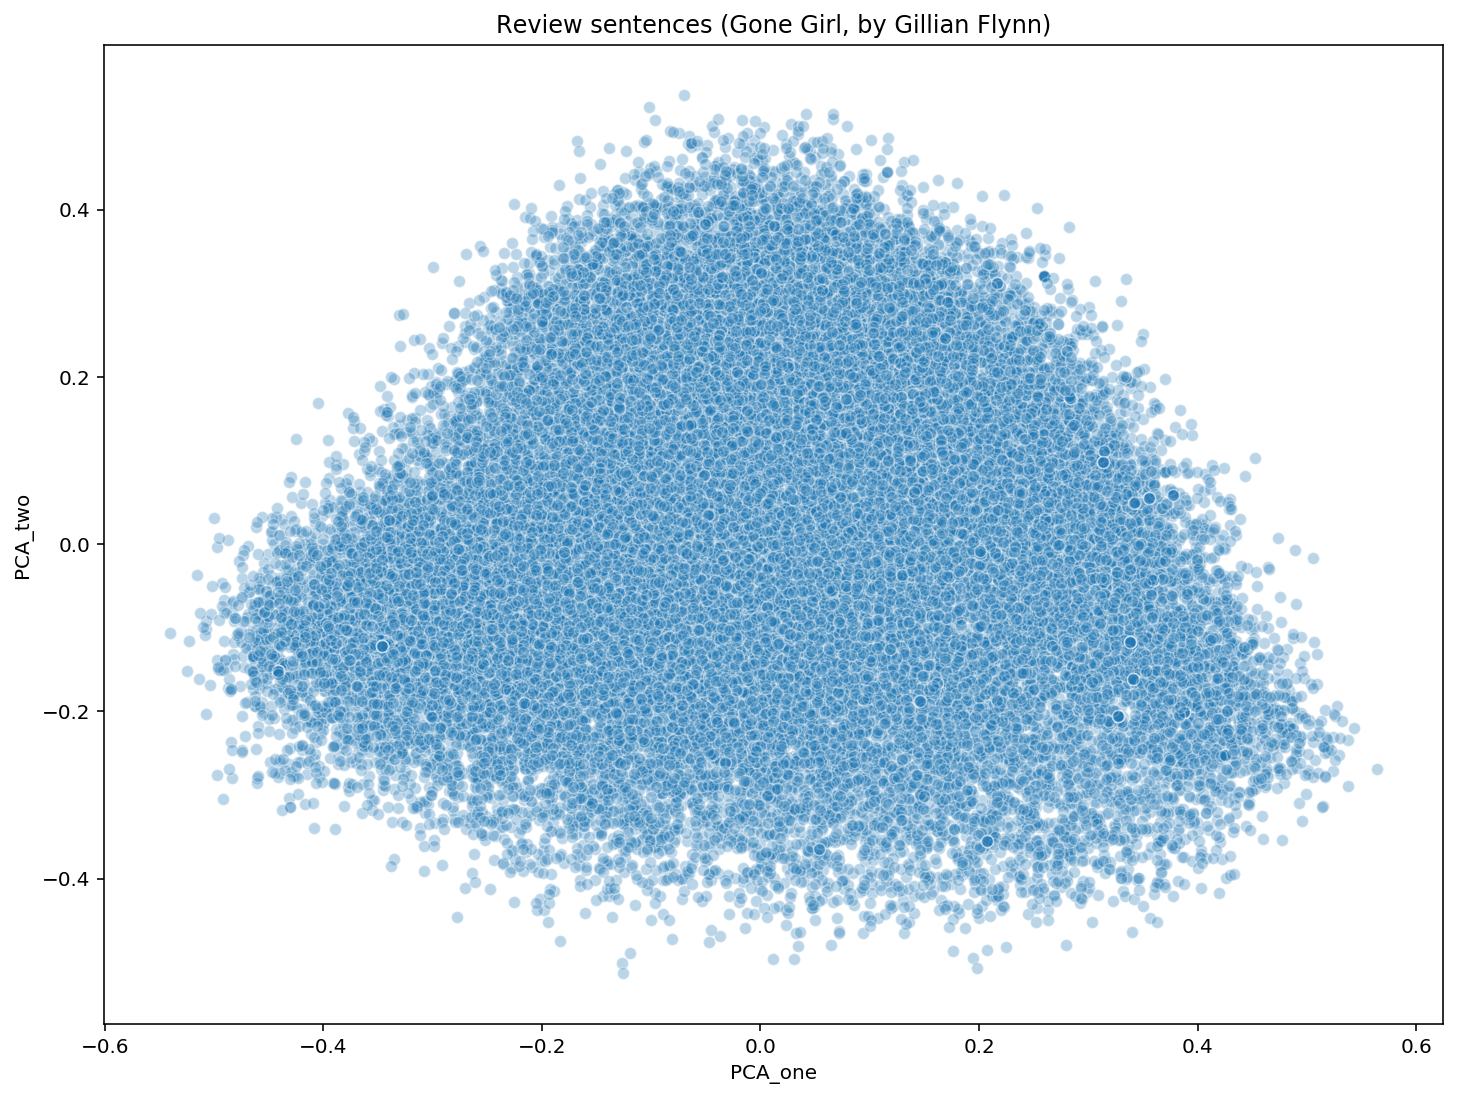

In [7]:
# Plot our full undifferentiated dataset
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', data=pca_df, alpha=0.3)
plt.title('Review sentences (Gone Girl, by Gillian Flynn)')
plt.savefig('viz/full_plot_gg.png', dpi=200)
plt.show()

Unsurprisingly, our full dataset looks like a big clump of data points with no obvious clusters. Let's see how our algorithm sees it.

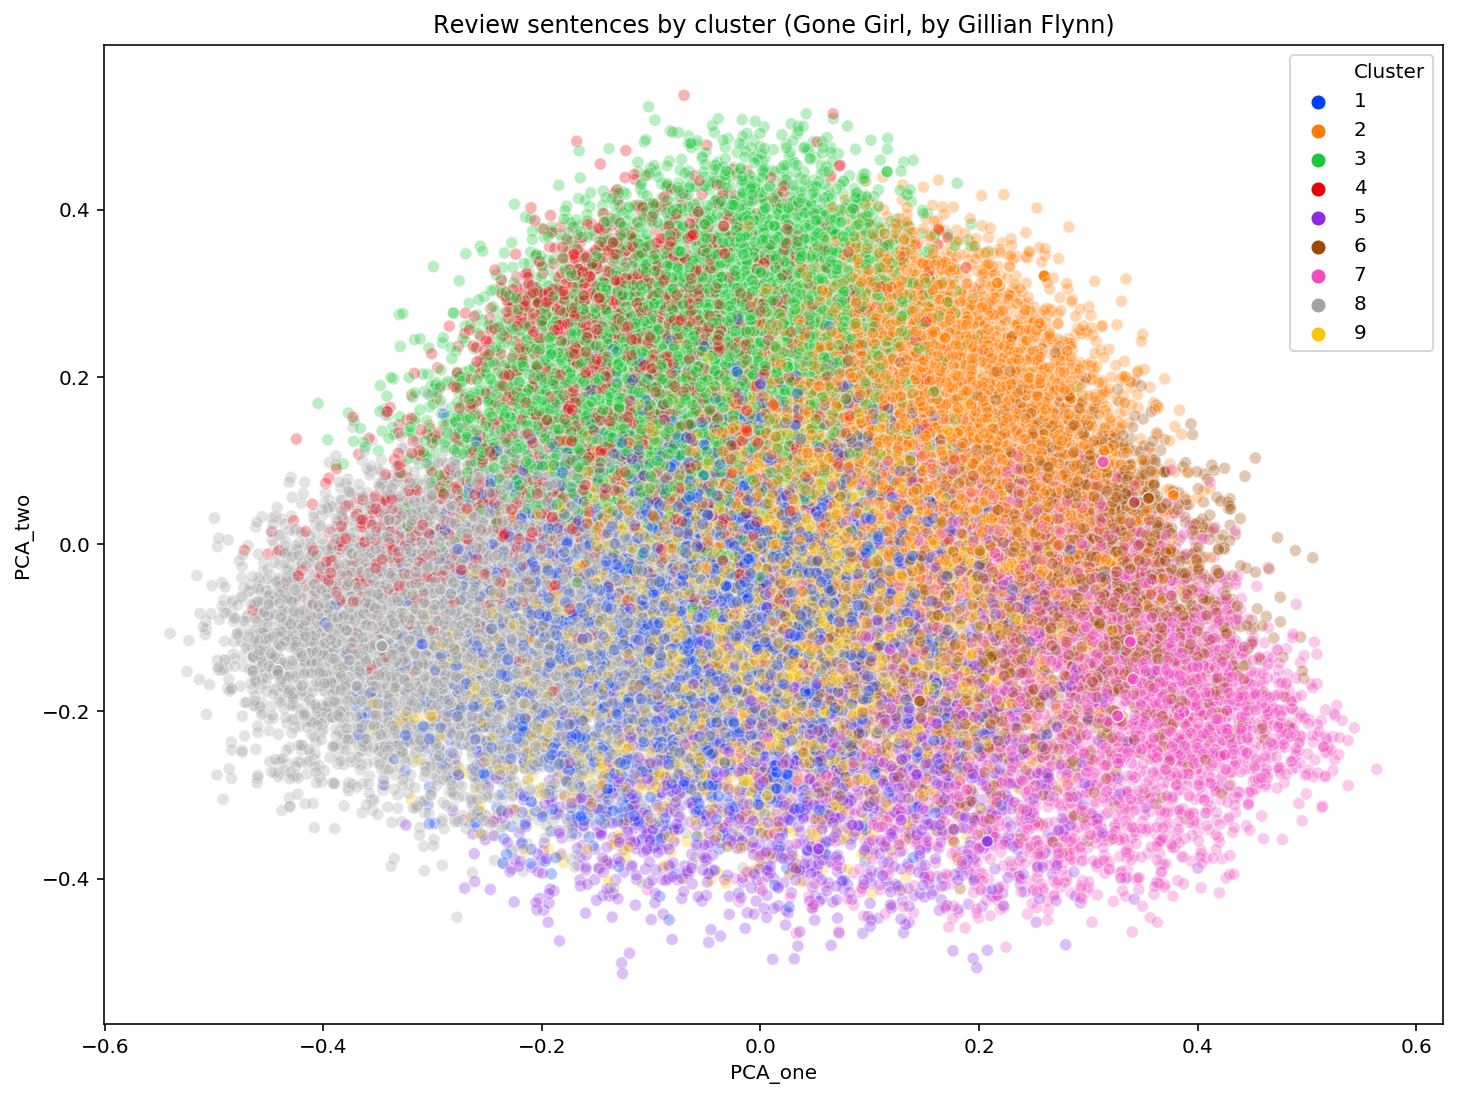

In [8]:
# Plot our dataset coloured by cluster
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', hue='Cluster', data=pca_df, 
                palette=sns.color_palette("bright", k), alpha=0.3)
plt.title('Review sentences by cluster (Gone Girl, by Gillian Flynn)')
plt.savefig('viz/cluster_plot_gg.png', dpi=200)
plt.show()

This is interesting! Though some of the clusters appear clumped together (like #3 and #4, and #1 and #9), others appear in clearly distinct regions (like #2, #7, and #8).

Now, instead of looking at our full dataset, let us look at only those points that we've identified as occupying the centre of each cluster.

In [10]:
# Set the number of cluster centre points to look at for the purposes of visualization
centre_size = int(len(sentences) * 0.02)

# Initialize list variable to store indices of cluster centre points
centre_pt_ids = []

# Loop through number of clusters
for i in range(k):

    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]

    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)

    # Find the sentences with the highest inner products
    centre_ips = pd.Series(ips).nlargest(centre_size)   
    
    # Add indices of cluster centre points to master list
    centre_pt_ids.append(centre_ips.index)

# Flattern list of indices
centre_pt_ids = [item for sublist in centre_pt_ids for item in sublist]

# Create new dataframe with only the cluster centre points 
centre_df = pca_df.iloc[centre_pt_ids]

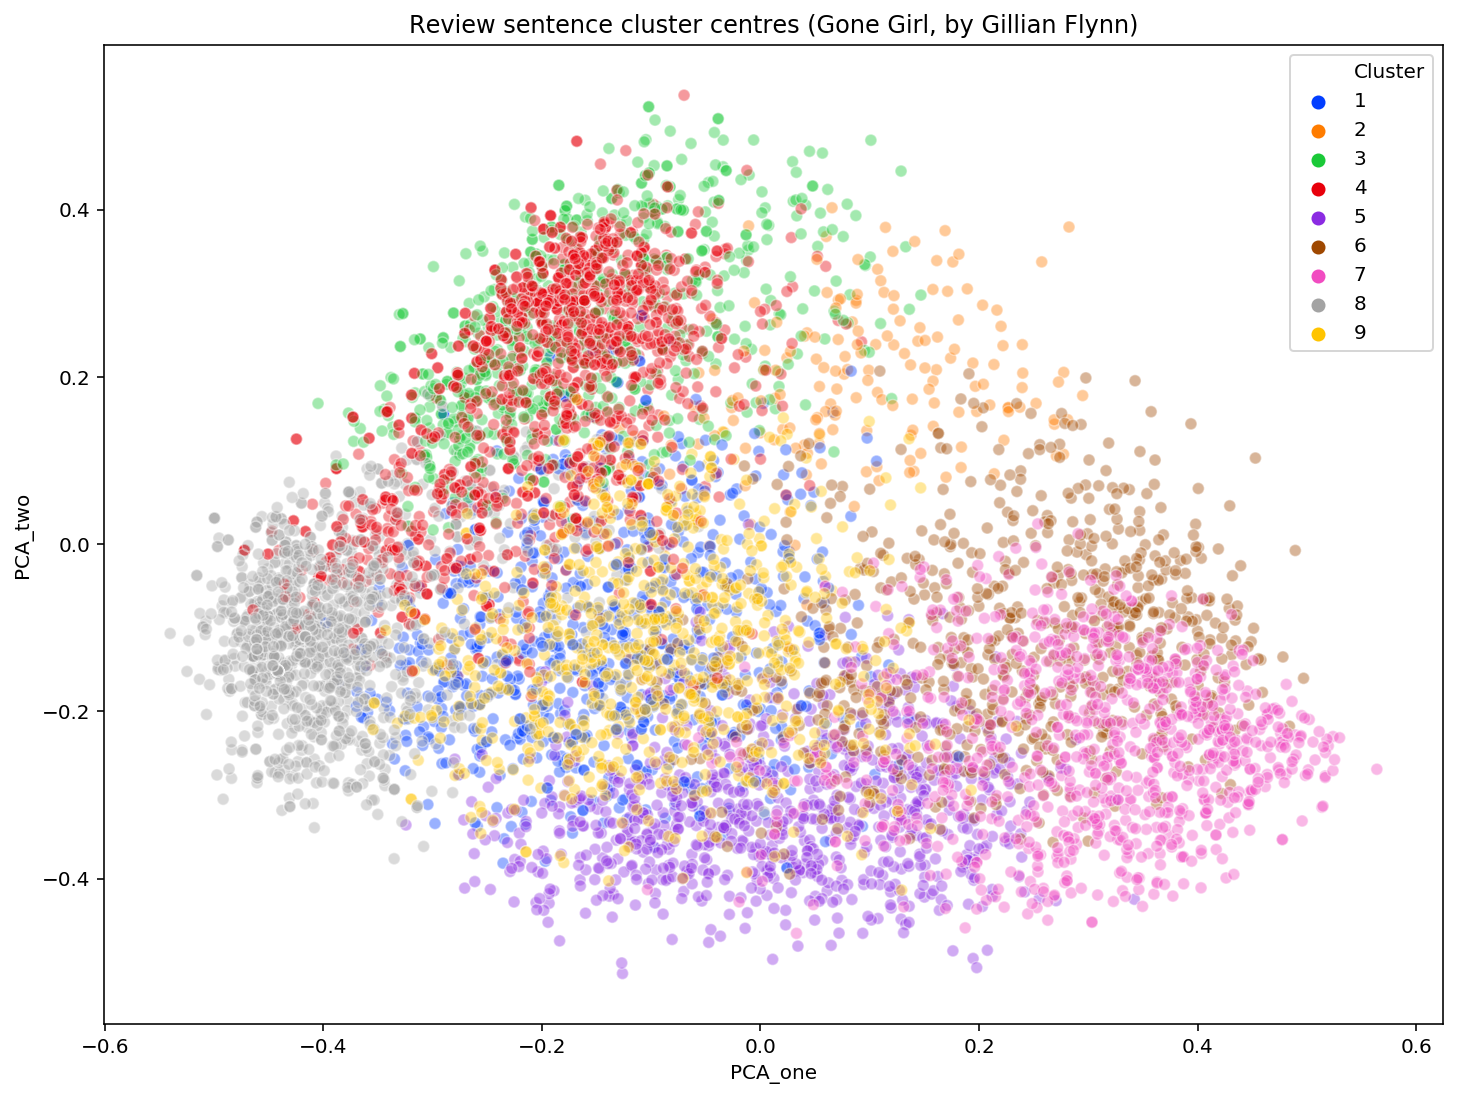

In [11]:
# Plot cluster centre points
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', hue='Cluster', data=centre_df, 
                palette=sns.color_palette("bright", k), alpha=0.4)
plt.title('Review sentence cluster centres (Gone Girl, by Gillian Flynn)')
plt.savefig('viz/centre_plot_gg.png', dpi=200)
plt.show()

These cluster centres appear even more distinct. Pretty cool! Though not too much should be read into this plot, given the degree of dimension reduction, it does give some indication that our model is working as it should.

Does what we're seeing visually correspond with the output of our model – i.e., the sentences? Let us load up these sentences.

In [12]:
# Set the number of cluster centre points to look at for the purposes of calculating centre density score
centre_size = int(len(sentences) * 0.05)

# Loop through number of clusters
for i in range(k):

    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]

    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)

    # Find the sentences with the highest inner products
    top_indices = pd.Series(ips).nlargest(n).index
    top_sentences = list(sentences[top_indices])

    # Calculate centre density score of cluster
    centre_ips = pd.Series(ips).nlargest(centre_size)
    density_score = round(np.mean(centre_ips), 5)

    print(f'Cluster #{i+1} sentences (density score: {density_score}):\n')
    print(*top_sentences, sep='\n')
    print('\n')

Cluster #1 sentences (density score: 0.34847):

It was a very quick read and I enjoyed the twists in the plot.
The book has an intriguing premise, and shocking twists, but I wanted a more satisfying ending.
The plot has so many twists and turns in it that I felt it was a little hard to keep up and defantly hard to figure out the ending, which I do in a murder mystery novel.
The suspense was great and the plot twists were very interesting, however, it just ended.
I loved the plot twists and the unexpected turns in this tale.
I guess that's what thrillers are supposed to do, but I enjoyed the twists and plot surprises before it became anti-climactic.
It is an amazing psychological thriller, very well written and full of plot twists and turns.
The writing was excellent, the plot twists were surprising, it was suspenseful and i couldn't put it down.


Cluster #2 sentences (density score: 0.15072):

It was so disturbingly messed up in a wonderful "I need to keep reading" type of way!
I'm pr

Some observations:

- Cluster #4, which has the highest centre density score, also appear the most clumped together in the cluster centres plot
- Clusters #3 and #4, which appear to overlap in the plot, are similar in theme: both concern the book's ending
- Clusters #6 and #7, which also appear to overlap in the plot, are likewise similar in theme: both are talking about the book's husband and wife protagonists
- Clusters #1 and #9, which appear to overlap entirely but are also fairly spread out, both concern aspects of how the book is written
- Clusters #5 and #8, which occupy their own regions in the plot apart from all the other clusters, are fairly uniform in their content

All of which is to say, it seems that what we're seeing in the plot does indeed correspond to the results of our model.

As one last step, let's try visualizing a different set of reviews and see how that plot compares. Here we'll use the reviews of Ted Chiang's *Exhalation*.

In [14]:
# Set path for processed file
file_path = 'data/41160292_exhalation_stories.csv'

# Set number of clusters to create (k), and number of sentences to display (n)
k = 6
n = 8

# Read in processed file as dataframe
df = pd.read_csv(file_path)

# Copy sentence column to new variable
sentences = df['sentence'].copy()

# Vectorize sentences
sentence_vectors = embed(sentences)

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(sentence_vectors);

In [15]:
# Instantiate PCA transformer with 2 dimensions
pca_transform = PCA(n_components=2)

# Fit the transformer
pca_transform.fit(sentence_vectors)

# Transform our data
sentences_pca = pca_transform.transform(sentence_vectors)

print('Proportion of total variance explained by each principal component: {}'.format(pca_transform.explained_variance_ratio_))

Proportion of total variance explained by each principal component: [0.05161743 0.04019346]


In [16]:
# Create a dataframe out of our transformed sentence vectors
pca_df = pd.DataFrame(sentences_pca, columns=['PCA_one', 'PCA_two'])

# Add column indicating the cluster number of each sentence (adding 1 so that the first cluster is number 1, not 0)
pca_df['Cluster'] = kmeans_model.labels_ + 1

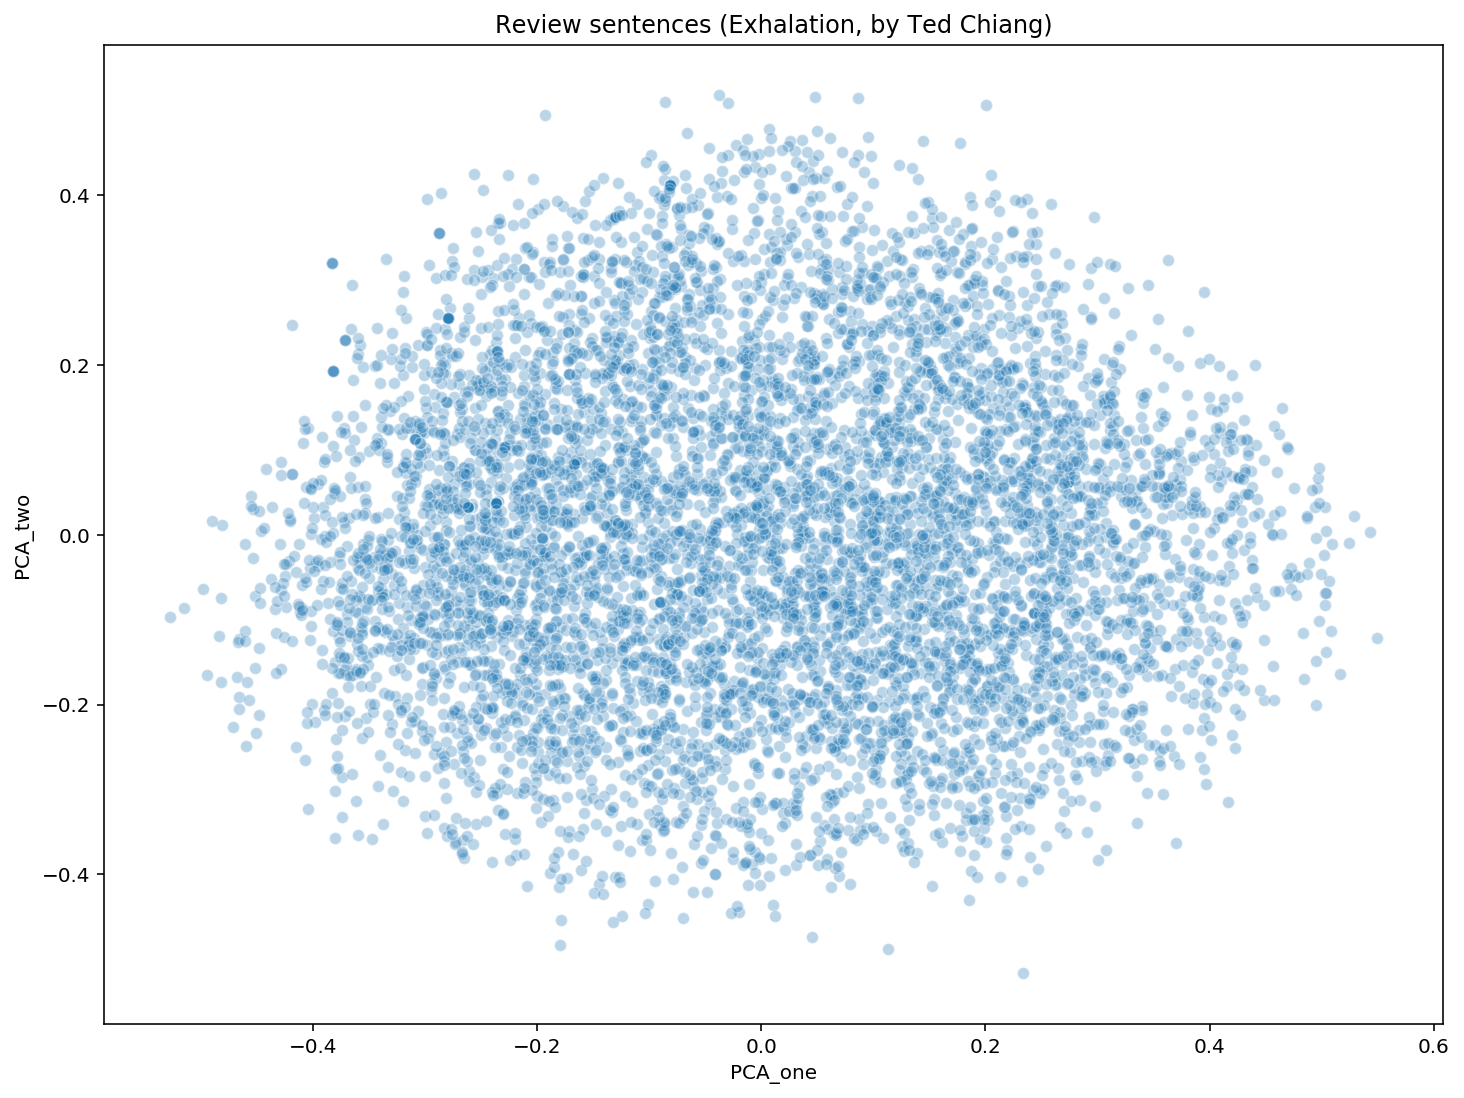

In [17]:
# Plot our full undifferentiated dataset
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', data=pca_df, alpha=0.3)
plt.title('Review sentences (Exhalation, by Ted Chiang)')
plt.savefig('viz/full_plot_ex.png', dpi=200)
plt.show()

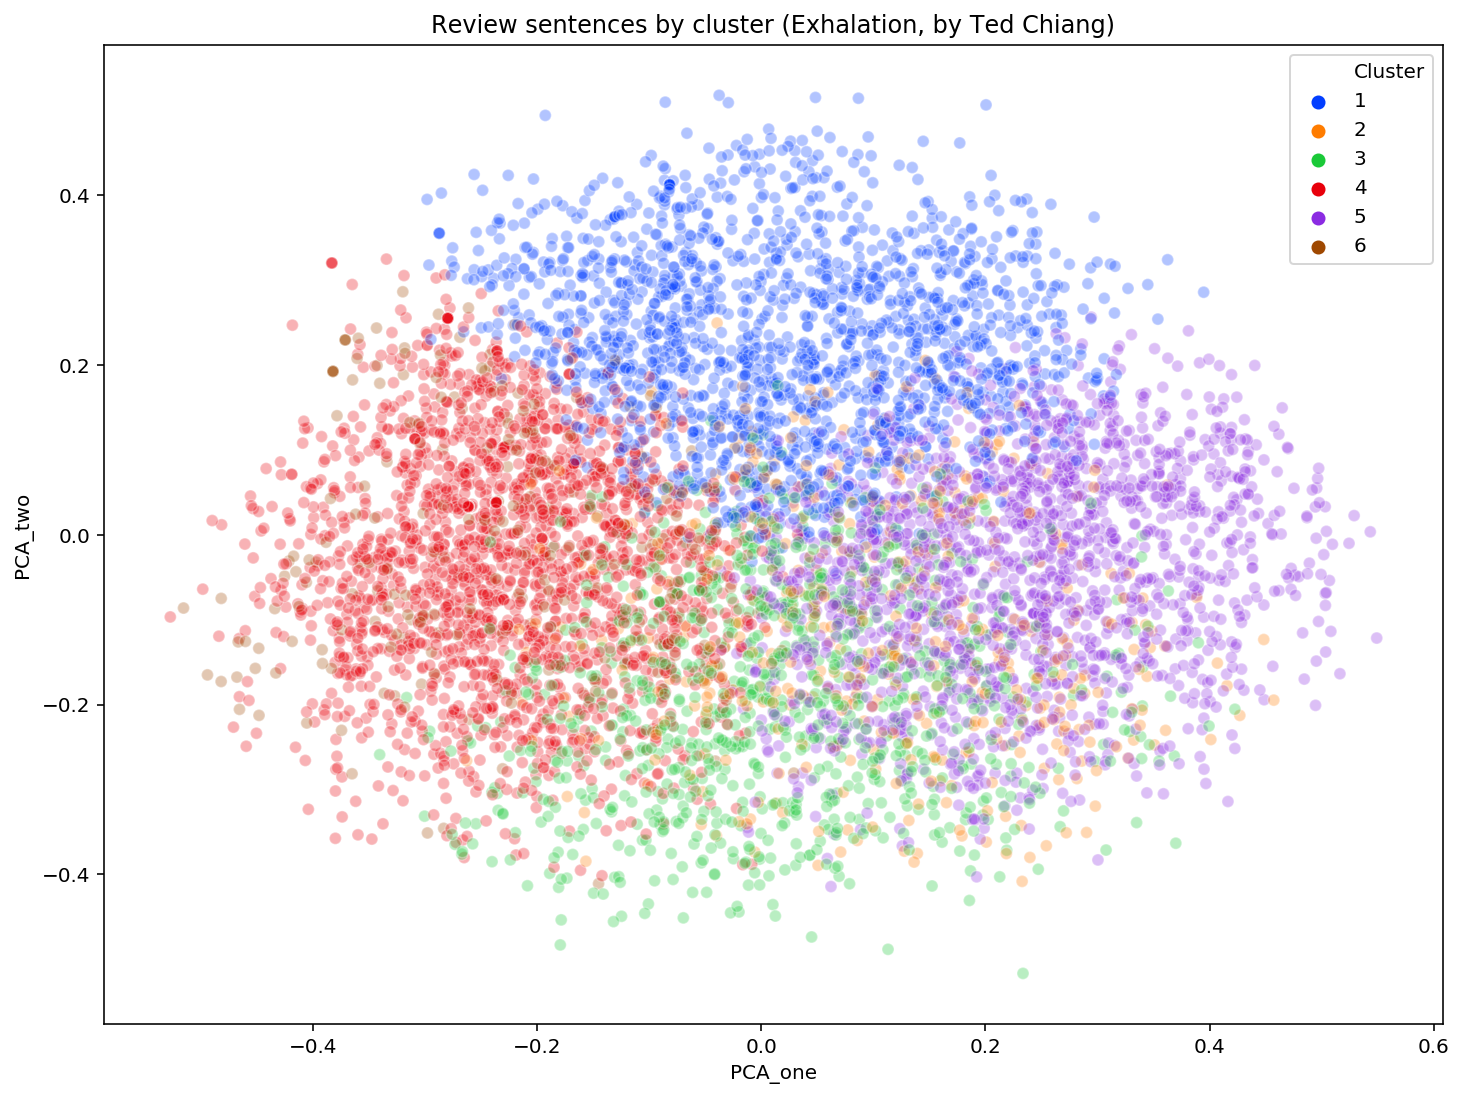

In [18]:
# Plot our dataset coloured by cluster
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', hue='Cluster', data=pca_df, 
                palette=sns.color_palette("bright", k), alpha=0.3)
plt.title('Review sentences by cluster (Exhalation, by Ted Chiang)')
plt.savefig('viz/cluster_plot_ex.png', dpi=200)
plt.show()

In [19]:
# Set the number of cluster centre points to look at for the purposes of visualization
centre_size = int(len(sentences) * 0.04)

# Initialize list variable to store indices of cluster centre points
centre_pt_ids = []

# Loop through number of clusters
for i in range(k):

    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]

    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)

    # Find the sentences with the highest inner products
    centre_ips = pd.Series(ips).nlargest(centre_size)   
    
    # Add indices of cluster centre points to master list
    centre_pt_ids.append(centre_ips.index)

# Flattern list of indices
centre_pt_ids = [item for sublist in centre_pt_ids for item in sublist]

# Create new dataframe with only the cluster centre points 
centre_df = pca_df.iloc[centre_pt_ids]

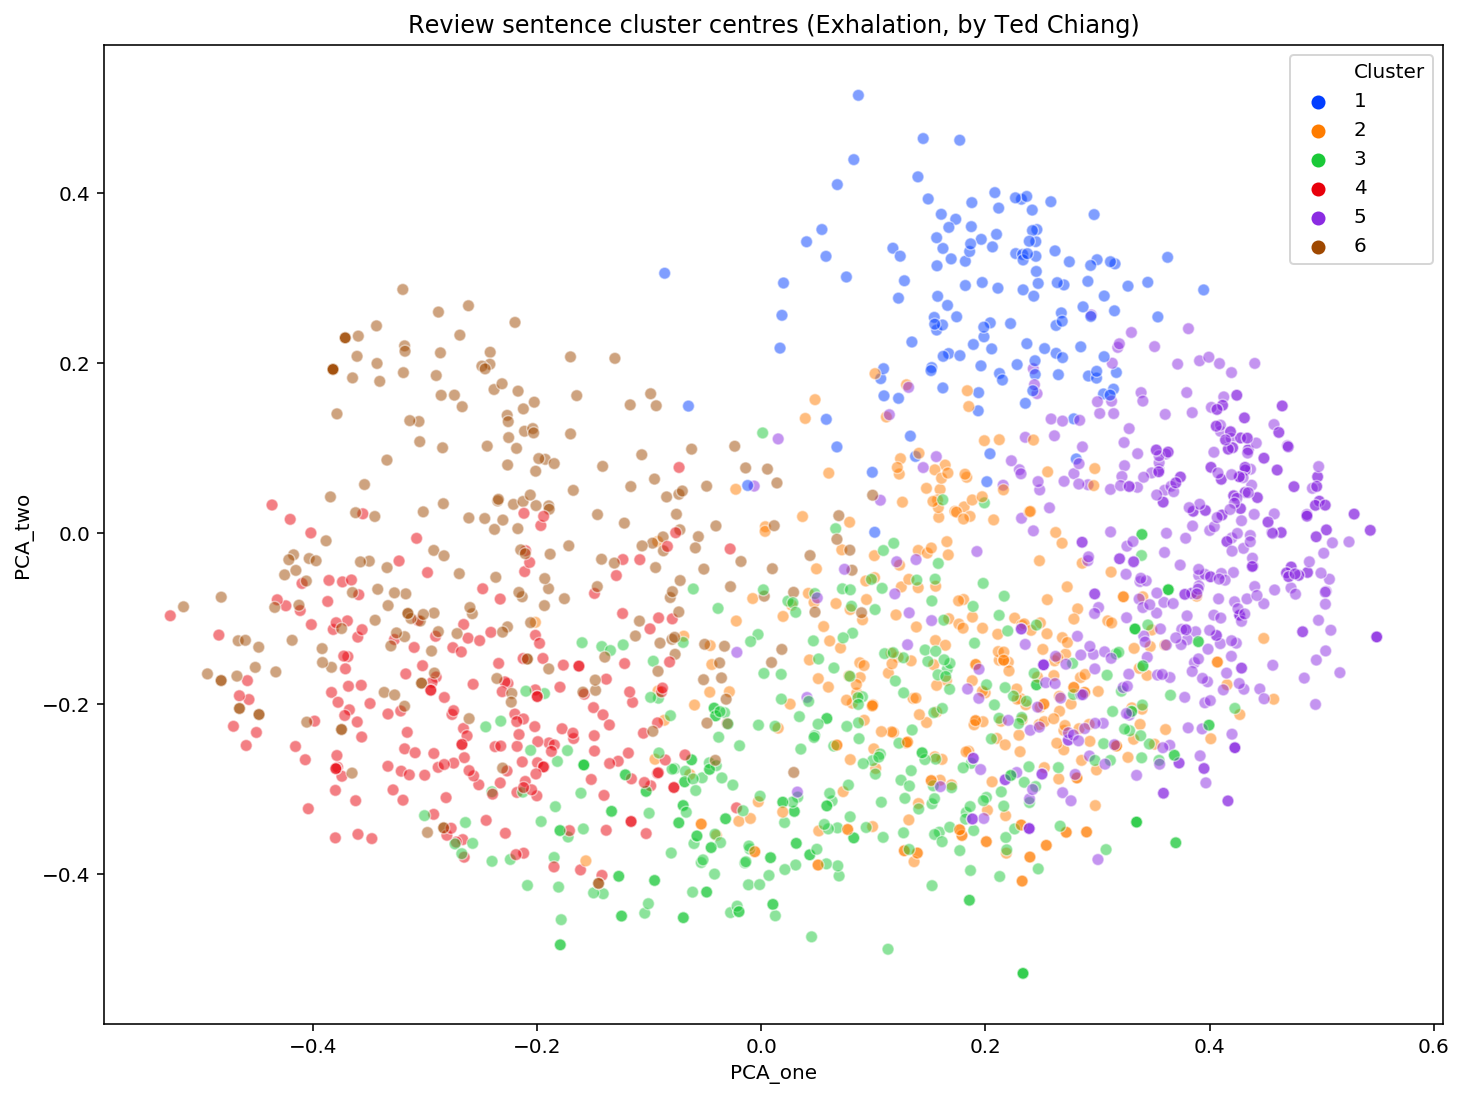

In [20]:
# Plot cluster centre points
plt.figure()
sns.scatterplot(x='PCA_one', y='PCA_two', hue='Cluster', data=centre_df, 
                palette=sns.color_palette("bright", k), alpha=0.5)
plt.title('Review sentence cluster centres (Exhalation, by Ted Chiang)')
plt.savefig('viz/centre_plot_ex.png', dpi=200)
plt.show()

In [21]:
# Set the number of cluster centre points to look at for the purposes of calculating centre density score
centre_size = int(len(sentences) * 0.05)

# Loop through number of clusters
for i in range(k):

    # Define cluster centre
    centre = kmeans_model.cluster_centers_[i]

    # Calculate inner product of cluster centre and sentence vectors
    ips = np.inner(centre, sentence_vectors)

    # Find the sentences with the highest inner products
    top_indices = pd.Series(ips).nlargest(n).index
    top_sentences = list(sentences[top_indices])

    # Calculate centre density score of cluster
    centre_ips = pd.Series(ips).nlargest(centre_size)
    density_score = round(np.mean(centre_ips), 5)

    print(f'Cluster #{i+1} sentences (density score: {density_score}):\n')
    print(*top_sentences, sep='\n')
    print('\n')

Cluster #1 sentences (density score: 0.19437):

I didn't find myself enjoying the read much though.
I liked this book, at least I wanted to, but every time I opened this it felt like a chore.
I don't really know what else to say about this one other than I loved it!
I enjoyed the book, but not as much as the blurbs led me to expect.
I enjoyed this one even more than Chiang’s first collection, having trouble putting it down.
I ended up not liking these stories as much as I was expecting, so I feel pretty disappointed.
I didn't like it that much but still had interest to see the end.
It was mostly pretty good, but I felt the ending really let the rest of the story down.


Cluster #2 sentences (density score: 0.37945):

Ted Chiang is maybe the best living writer of the science-fiction short story.
Ted Chiang is crazy good!Exhalation is a collection of short stories written by Ted Chiang over the years.
I cannot say if Ted Chiang is as insightful and creative as his short stories lead me t

These are nice results. First, all the plots for *Exhalation* look very different from the plots for *Gone Girl*. Second, the cluster centre plot shows six clearly distinguishable clusters. Lastly, the appearance of the clusters on the plot corresponds pretty well to the model's output; for instance:

- Clusters #2, #3, and #5, all of which share a good amount of overlap in the plot, also share a good amount of semantic overlap in their sentences: all make mention of science fiction and/or short stories
- Cluster #1, which appears to be on its own in the plot, is also pretty semantically different from the other clusters, being the only cluster whose sentences are generally negative

All of these results suggest that, while these visualization by no means provide a perfect representation of our datasets, they do provide some insights into them, and can be used to get a quick visual sense of how our model works.

## Visualizing with Tensorflow's Embedding Projector

As a final step, we present some steps to export our data so that it can be loaded into Tensorflow's [Embedding Projector](https://projector.tensorflow.org/), which allows us to view and manipulate a three-dimensional PCA reduction of our data.

In [23]:
# Set path for processed file
file_path = 'data/49628_cloud_atlas.csv'

# Set number of clusters to create
k = 6

# Read in processed file as dataframe
df = pd.read_csv(file_path)

# Copy sentence column to new variable
sentences = df['sentence'].copy()

# Vectorize sentences
sentence_vectors = embed(sentences)

# Instantiate the model
kmeans_model = KMeans(n_clusters=k, random_state=24)

# Fit the model
kmeans_model.fit(sentence_vectors);

# Save sentence vectors to TSV
sentence_array = np.array(sentence_vectors)
np.savetxt('viz/cloud_atlas.tsv', sentence_array, delimiter='\t')

# Save sentences along with their cluster labels to TSV
sentence_df = pd.DataFrame(sentences)
cluster_labels = kmeans_model.labels_ + 1
sentence_df['cluster'] = cluster_labels
sentence_df.to_csv('viz/cloud_atlas_labels.tsv', sep='\t', index=False)